# TRANSFER FUNCTIONS FOR CLOSED LOOP SYSTEMS

This notebook discusses how to create a transfer function for a closed loop including analysis of the resulting transfer function.

# Preliminaries

In [1]:
import control
import controlSBML as ctl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy
import tellurium as te
from IPython.display import Image

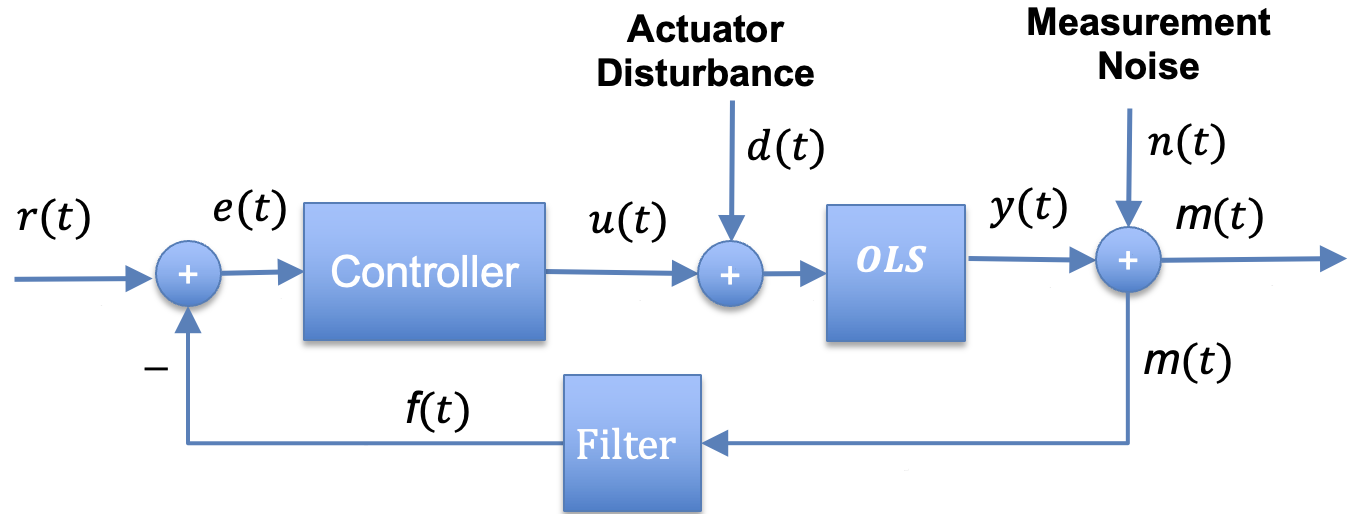

In [2]:
Image("closed_loop_system.png", width = 600, height = 300)

The starting point for transfer function analysis is to identify the system or systems to
be analyzed.
Here, we only consider single input single output (SISO) systems.
So, we need to identify which input/output relationships are of interest.

| Input  | Output | Why of interest?        | Desired DC Gain | Desired poles |
|--------|--------|-------------------------|-----------------|---------------|
| $r(t)$ | $m(t)$ | convergence to set point| 1               | very negative |
| $n(t)$ | $m(t)$ | influence of noise      | 0               | very negative |
| $d(t)$ | $m(t)$ | influence of disturbance| 0               | very negative |
| $r(t)$ | $e(t)$ | convergence to set point| 0               | very negative |
| $n(t)$ | $e(t)$ | influence of noise      | 0               | very negative |
| $d(t)$ | $e(t)$ | influence of disturbance| 0               | very negative |

Some other considerations:
1. Will the OLS always be within the operating region we designed for its input?
1. What are the maximum magnitudes of $d(t)$ and $n(t)$?
1. What trade-offs can we accepts?
    1. Achieved desired DC Gain but have oscillations? 
    1. Achieved desired DC Gain but have longer settling times?

## Note on notation
When we're talking about a system in isolation (e.g., a controller, a filter, an open loop system),
we use $u(t)$ for the input signal and $y(t)$ for the output signal.

# Helpers

In [3]:
TIMES = np.linspace(0, 10, 100)

In [4]:
TEST_MODEL = """
species S1, S2, S3

S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 =2
"""
ctlsb = ctl.ControlSBML(TEST_MODEL, input_names=["S1", "S2"], output_names=["S3"])
TEST_SYS = ctlsb.makeNonlinearIOSystem("TEST_SYS")

In [5]:
class PlotResult(object):
    def __init__(self, times = None, y_arr=None, ax=None):
        self.times = times
        self.y_arr = y_arr
        self.ax = ax
        
    def __repr__(self):
        return ""

## ``plotSys``

In [6]:
def plotSys(sys, times=None, initial_values=None, forced_input=None,
            title="", ax=None, output_labels=None, figsize=None,
            ylim=None, is_legend=True, is_plot=True):
    """
    Plots the system, either a NonlinearIOSystem or a TransferFunction.
    
    Parameters
    ----------
    sys: NonlinearIOSystem or TransferFunction
    times: list-float (times for simulation)
    initial_values: list-float
    forced_input: list-float (default is step)
    figsize: (int, int)
    ax: matplotlib.Axes
    output_labels: list-str (names for output labels)
    title: str (plot title)
    is_legend: bool (include legend)
    
    Returns
    -------
    PlotResut
    """
    if "NonlinearIOSystem" in str(type(sys)):
        is_nonlinear = True
    else:
        is_nonlinear = False
    if times is None:
        times = TIMES
    if forced_input is None:
        ncol = len(times)
        nrow = len(sys.input_labels)
        forced_input = np.array([np.repeat(1, nrow) for _ in range(ncol)])
        forced_input = np.reshape(forced_input, (nrow, ncol))
    if (initial_values is None) and is_nonlinear:
        initial_values = ctl.makeStateVector(sys)
    if figsize is None:
        figsize = (5, 5)
    if ax is None:
        _, ax = plt.subplots(1, figsize=figsize)
    if output_labels is None:
        if len(sys.output_labels) == 1:
            output_labels = ["y"]
        else:
            output_labels = list(sys.output_labels)
    # Simulate the system
    if is_nonlinear:
        t, y = control.input_output_response(sys, times, forced_input, initial_values)
    else:
        t, y = control.forced_response(sys, T=times, U=forced_input)
    # Plot the response
    num_output = len(output_labels)
    if num_output == 1:
        if y.ndim == 1:
            plt.plot(t, y)
        else:
            plt.plot(t, y[0])
    else:
        for idx in range(num_output):
            ax.plot(t, y[idx])
    if is_legend:
        ax.legend(output_labels)
    ax.set_xlabel("time")
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(ylim)
    if not is_plot:
        plt.close()
    return PlotResult(times=t, y_arr=y, ax=ax)
    
# Tests
times = T = np.linspace(0, 70, 500)
plot_result = plotSys(TEST_SYS, times, is_plot=False)
assert(len(plot_result.times) == len(plot_result.y_arr[0]))
#
numerator = 5
tf = control.TransferFunction([numerator], [1])
plot_result = plotSys(tf, times, forced_input=1, is_plot=False)
assert(len(plot_result.times) == len(plot_result.y_arr))
assert(plot_result.y_arr[0] == numerator)
print("OK!")

OK!


# Models

## Linear

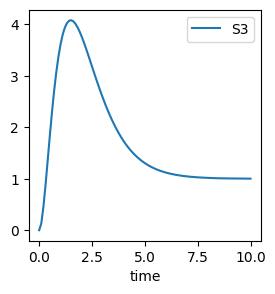

In [7]:
LINEAR_MDL = """
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> S4; k3*S3

k1 = 2
k2 = 1.5
k3 = 1
S1 = 10
S2 = 0
S3 = 0
S4 = 0
"""
ctlsb = ctl.ControlSBML(LINEAR_MDL, input_names=["S1"], output_names=["S3"])
LINEAR_BLDR = ctlsb.makeSISOTransferFunctionBuilder(system_name="linear_sys")
_ = plotSys(LINEAR_BLDR.sys, figsize=(3,3), output_labels=["S3"])

## Wolf

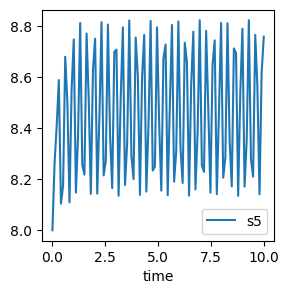

In [8]:
ctlsb = ctl.ControlSBML("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml", 
                        input_names=["at"], output_names=["s5"])
WOLF_BLDR = ctlsb.makeSISOTransferFunctionBuilder(system_name="wolf_sys")
_ = plotSys(WOLF_BLDR.sys, figsize=(3,3), output_labels=["s5"])

# Transfer Functions for PID Controller

The controllers considered here are systems that input the control error and produce a control signal used
to regulate the system under control.
The input signal is $e(t)$ and the output signal is $u(t)$.

## P Controller

A **proportional controller** has the parameter $k_P$.
This controller outputs a signal that is proportional to the control error.
That is, for this system, the input $u(t)$ is the control error and the output $y(t)$ is the control input to the OLS.

**State and Output Equations**
1. There is no state, and so there is no state equation.
1. Output equation: $y(t) = k_P u(t)$.

**Laplace Transforms**
1. $Y(s) = k_P U(s)$

**Transfer Functions**
1. $G_P(s) = \frac{Y(s)}{U(s)} = k_P$

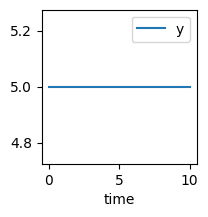

In [9]:
# Construct the transfer function
kP = 5
gp_tf = control.TransferFunction([kP], [1])
plotSys(gp_tf, forced_input=1, figsize=(2,2))

## I Controller

An **integral controller** has the parameter $k_I$.
This controller outputs a signal that is proportional to the *integral* of the control error.
That is, $u(t) = k_I \int_0^{t} e(\tau) d \tau$.
The transfer function for this controller is $H_{I} (s) = \frac{k_I}{s}$.

**State and Output Equations**
1. The state $x(t) = \int_0^{t} u(\tau) d \tau$.
1. Output equation: $y(t) = k_I x(t)$.

**Laplace Transforms**
1. $Y(s) = \frac{k_I}{s} U(s)$

**Transfer Functions**
1. $G_I(s) = \frac{Y(s)}{U(s)} = \frac{k_I}{s}$

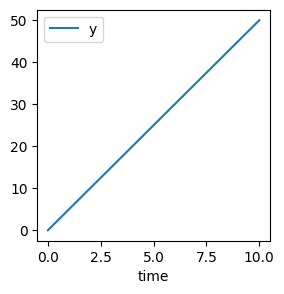

In [10]:
# Construct the transfer function
kI = 5
gi_tf = control.TransferFunction([kI], [1, 0])
plotSys(gi_tf, forced_input=1, figsize=(3,3))

## D Controller

An **differential controller** has the parameter $k_D$.
This controller outputs a signal that is proportional to the derivative of the control error.

**State and Output Equations**
1. The state $x(t) = \frac{d u(t)}{d t}$.
1. Output equation: $y(t) = k_D x(t)$.

**Laplace Transforms**
1. $Y(s) = s k_D U(s)$

**Transfer Functions** 
1. $G_D(s) = \frac{Y(s)}{U(s)} = k_D s$

In [11]:
# Construct the transfer function
kD = 5
# The following would cause an error because the transfer function is not "proper",
# That is, the numerator degree exceeds the degree of the denominator.
# gd_tf = control.TransferFunction([kD, 0], [1])

## PID Controller

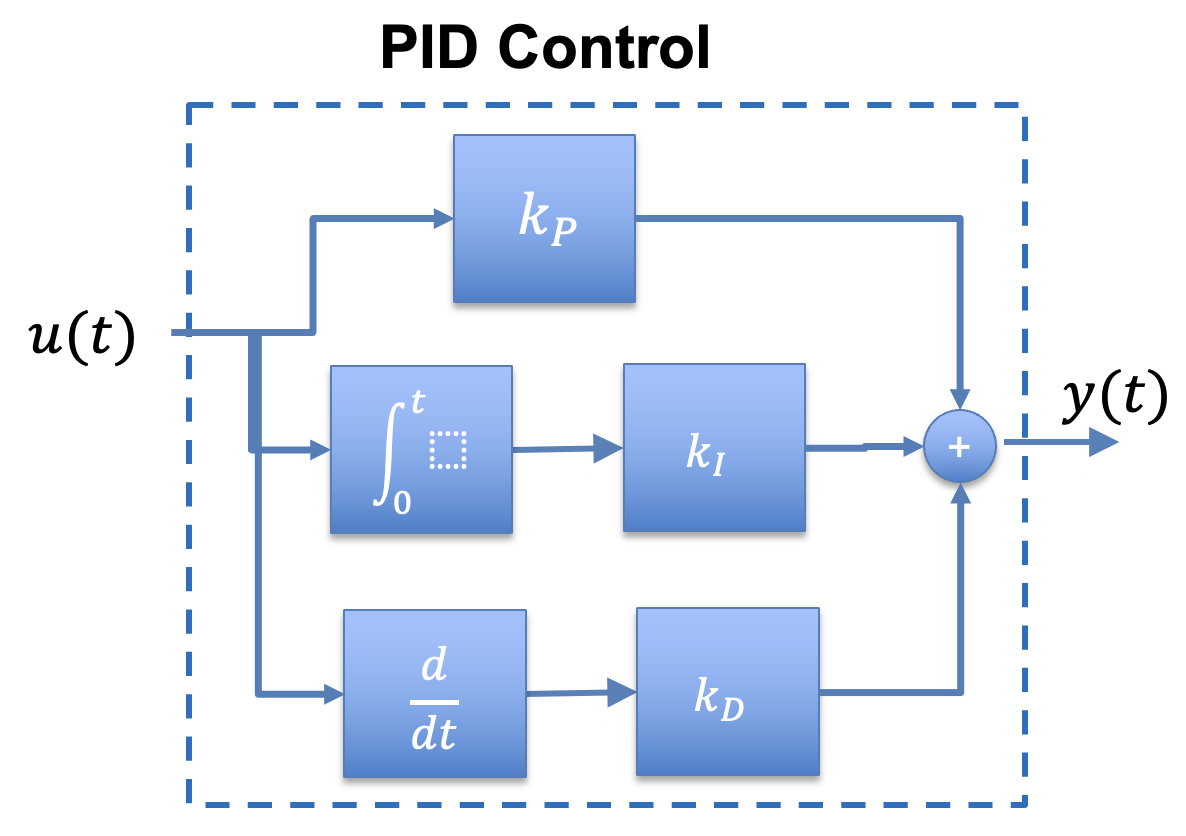

In [12]:
Image("pid_control.png", width = 300, height = 150)

PID control is the sum of the effects of the individual controllers.

$y_{PID}(t)$ is the sum of the signals output by the P, I, and D controllers.
So, $Y_{PID}(s)$ is the sum of these signals.
That is:
\begin{eqnarray}
Y_{PID} (s) & = & Y_P(s) + Y_I (s) + Y_D (s)\\
\end{eqnarray}

* The transfer function for the P controller is $G_P(s) = \frac{Y_P(s)}{U(s)}  = k_P$.
* The transfer function for  I controller is $G_I(s) = \frac{Y_I(s)}{U(s)} =  \frac{k_I}{s}$.
* The transfer function for  D controller is $G_D(s) = \frac{Y_D(s)}{U(s)} = k_D s$.

\begin{eqnarray}
G_{PID} (s) & = & \frac{Y_{PID}(s)}{U(s)} \\
& = & \frac{Y_P (s) + Y_I (s) + Y_D (s)}{U(s)} \\
& = & G_P (s) + G_I (s) + G_D (s) \\
& = & k_P + \frac{k_I}{s} + k_D s\\
\end{eqnarray}

## Transfer function for PI controller

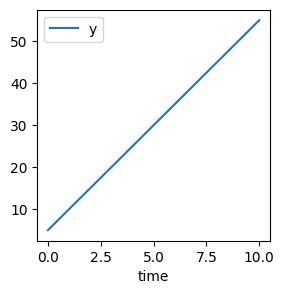

In [13]:
# Transfer function for a PI controller
gpi_tf = gp_tf + gi_tf
plotSys(gpi_tf, forced_input=1, figsize=(3,3))

In [14]:
def makePITransferFunction(kP=1, kI=0.1):
    """
    Parameters
    ----------
    kP: float (proportional parameter)
    kI: float (integral parameter)
    
    Returns
    -------
    control.TransferFunction
    """
    gP_tf = control.TransferFunction([kP], [1])
    gI_tf = control.TransferFunction([kI], [1, 0])
    return gP_tf + gI_tf

# Tests
gPI_tf = makePITransferFunction(kP=1, kI=0.1)
plotSys(gPI_tf, is_plot=False)
print("OK!")

OK!


## Questions
* What are the poles for a PI Controller?

# Transfer Function for Filter

The Time domain behavior of the filter is $\frac{d y (t)}{d t} = k_F u(t) - k_F y(t)$,
for $k_F \geq 0$.

The intuition beyond this equation is as follows. If $k_F$ is large, then $\frac{d y(t)}{dt}$ changes more with $u(t)$ and discounts more of $y(t)$. If $k_F$ is small, then $\frac{d y(t)}{dt}$ doesn't change much, which means that $y(t)$ is relatively unaffected by $u(t)$.

Is there state?

Yes. State is the averaged output, $y(t)$. That is, $x(t) = y(t)$.

## State equations

$\frac{d y (t)}{d t} = k_F u(t) - k_F y(t)$

## Laplace transform of state equations

$s Y(s) = k_F U(s) - k_F Y(s)$

## Solve for transfer function

\begin{eqnarray}
s Y(s) & = & k_F U(s) - k_F Y(s) \\
Y(s) ( s + k_F) & = & k_F U(s) \\
Y(s) & = & \frac{k_F U(s)}{s + k_F} \\
G_F(s) & = & \frac{Y(s)}{U(s)}  \\
& =& \frac{k_F}{s + k_F}
\end{eqnarray}

## Exploring filters

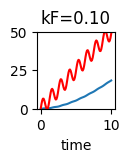

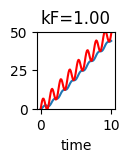

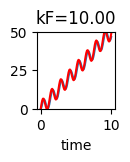

In [15]:
# Effect of the filter parameter on a linear increasing sine wave
forced_input = 5*np.sin(5*TIMES) + 5*TIMES # Linear increase
for kF in [0.1, 1, 10]:
    tf = control.TransferFunction([kF], [1, kF])
    plot_result = plotSys(tf, forced_input=forced_input, times=TIMES, figsize=(1,1), ylim=[0, 50],
           title="kF=%2.2f" % kF, is_legend=False)
    plot_result.ax.plot(TIMES, forced_input, color="red")

We see that $y(t)$ is smoother for small values of $k_F$, and $y(t)$ better approximates the signal trend (i.e., line slope) if $k_F$ is larger.

## Questions
1. What is the DC Gain of a filter?
1. Why must $k_F \geq 0$? Explain in terms of the poles of $F_F(s)$.
1. What is the effect of a large value of $k_F$? Explain in terms of the poles of $G_F(s)$.

# Transfer functions for a closed loop system

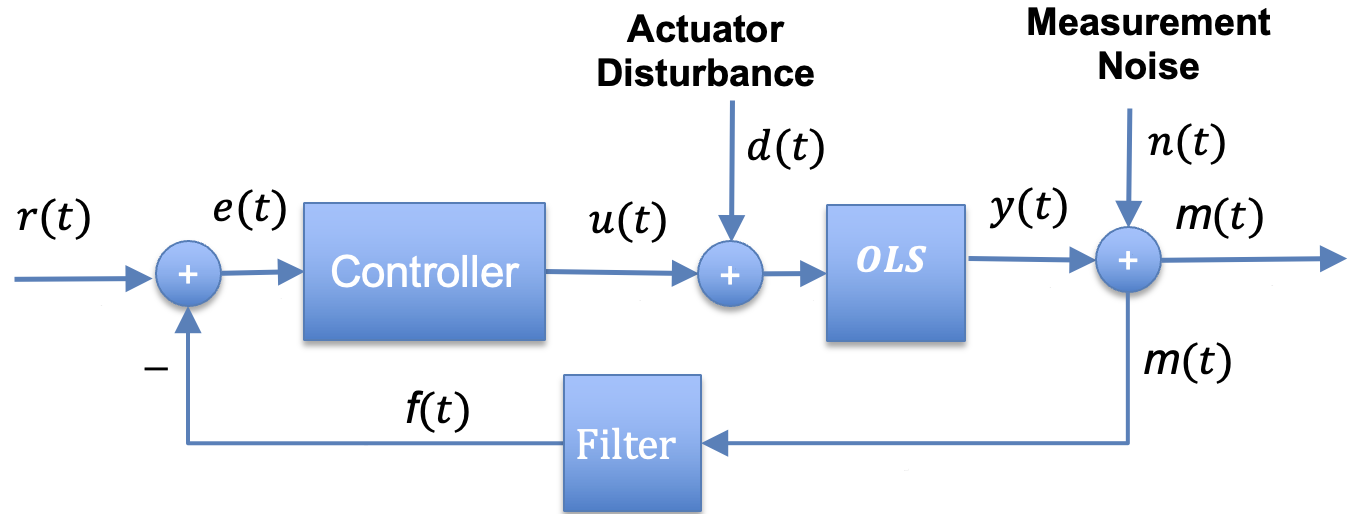

In [16]:
Image("closed_loop_system.png", width = 600, height = 300)

Define the transfer functions:
* $G_C (s)$: controller
* $G_F (s)$: filter
* $G_O (s)$: open loop system

Define the signals
* $R(s)$: reference input (set point)
* $D(S)$: disturbance
* $N(s)$: noise

## Key facts about Laplace transforms and transfer functions.
* **F1**: If system 1 with transfer function $G_1 (s)$ is in series with system 2 with transfer function $G_2(s)$,
then the transfer function the two systems in series is $G_1(s)G_2 (s)$.
* **F2**: If the Laplace transforms of signals $y_1(t)$, $y_2(t)$ are $Y_1 (s)$, $Y_2 (s)$,
the $\mathcal{L} (a_1 y_1 (t) + a_2 y_2 (t)) = a_1 Y_1 (s) + a_2 Y_2 (s)$.
* **F3**: Let $G(s)$ be the transfer function for a system with input $U(s)$ and output $Y(s)$.
Then, $Y(s) = U(s) G(s)$.

## Find the transfer function from $r(t)$ to $m(t)$.
That is, $G_{RM} = \frac{M(s)}{R(s)}$.

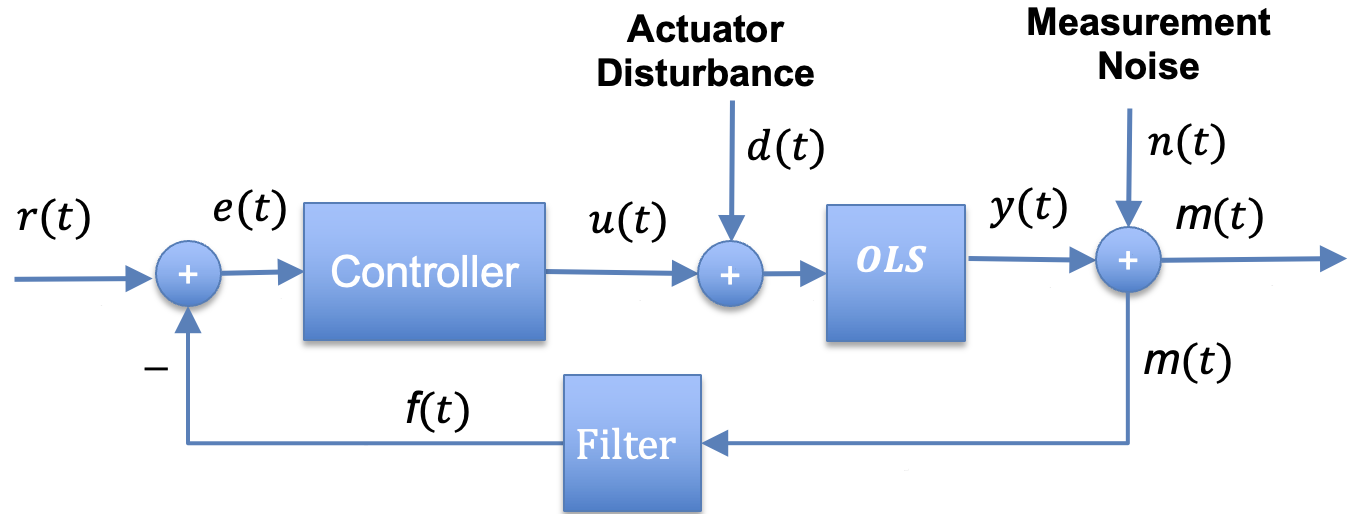

In [17]:
Image("closed_loop_system.png", width = 300, height = 150)

$G_{RM}$ assumes
that $n(t) = 0 = d(t)$. This means that we are analyzing a simplified diagram.

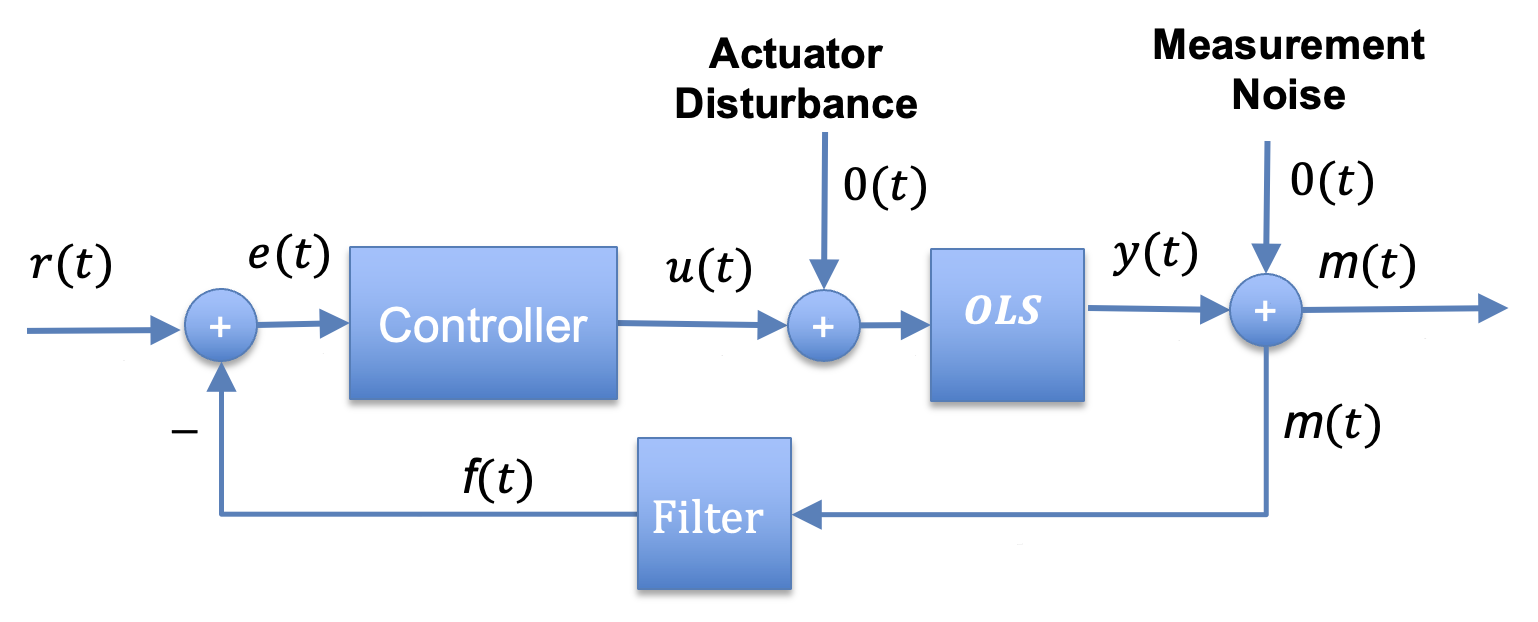

In [18]:
Image("simplified_closed_loop_system.png", width = 300, height = 150)

The Controller is in series with the OLS. This is called the **forward** system.
From F1, forward system has the transfer function $G_c(s) G_O (s)$.

### Steps

1. $M(s)$ is the output of the forward system, and $E(s)$ is its input.
From $F3$, $M(s) = E(s) G_c(s) G_O (s)$
1. Again from $F3$, $F(s) = M(s) G_F(s)$.
1. From $F2$, $E(s) = R(s) - F(s)$
1. Substituting (2) into (3), $E(s) = R(s) - M(s) G_F(s)$.
1. Solve for the transfer function.
\begin{eqnarray}
M(s) & = & E(s) G_C (s) G_O(s) \\
M(s)&  =& (R(s) - M(s) G_F(s) ) G_C (s) G_O(s) \\
M(s) ( 1 + G_C (s) G_O (s) G_F (s) )&  = & R(s) G_C (s) G_O(s) \\
G_{RM} (s) & = & \frac{M(s)}{R(s)} \\
& = & \frac{ G_C (s) G_O(s) }{1 + G_C (s) G_O(s) G_F(s)} \\
\end{eqnarray}

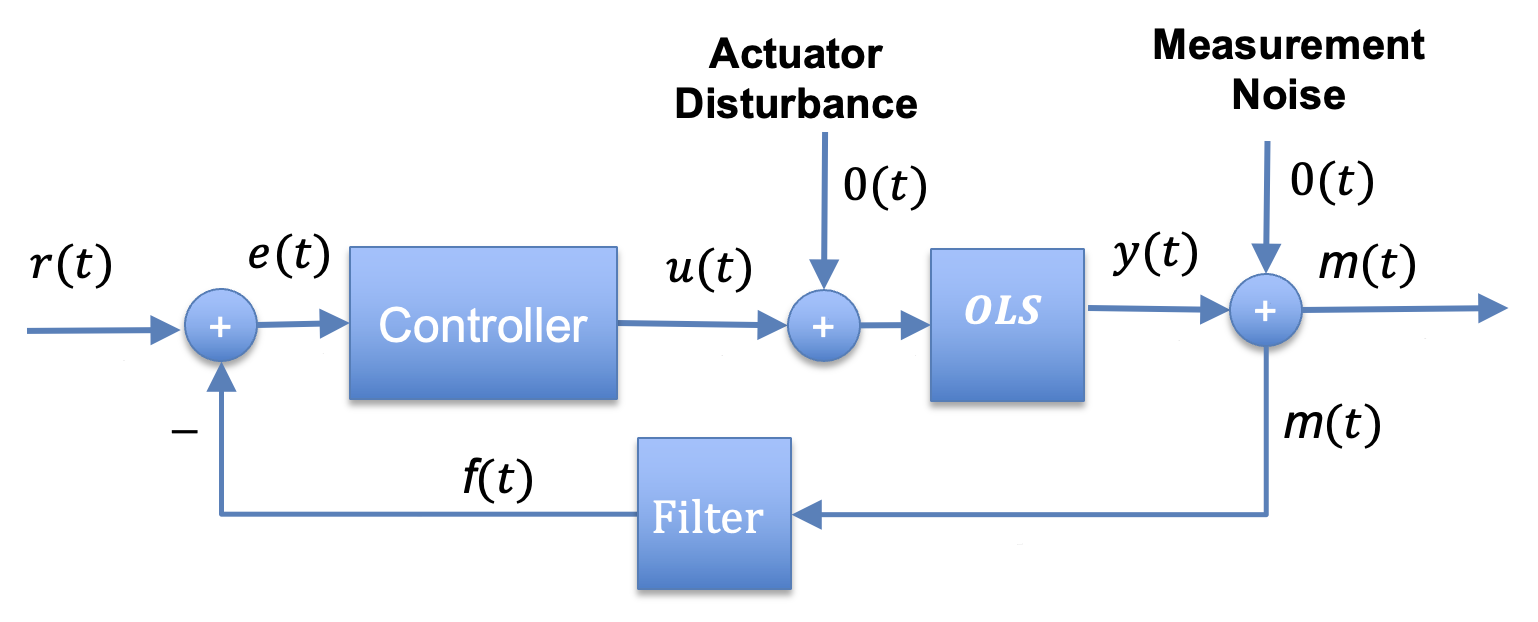

In [19]:
Image("simplified_closed_loop_system.png", width = 300, height = 150)

## Analysis

In [20]:
# Construct the transfer function from R to Y
gO_tf = control.TransferFunction([4.6], [10, 6.8]) # From sysid of linear system
gC_tf = makePITransferFunction(kP=1, kI=0.1)
gF_tf = control.TransferFunction([1], [1, 1])
gRM_tf = (gC_tf*gO_tf)/(1 + gC_tf*gO_tf*gF_tf)
for tf_str in ["gO_tf", "gC_tf", "gF_tf", "gRM_tf"]:
    print("%s\n%s\n\n"% (tf_str, eval(tf_str)))

gO_tf

   4.6
----------
10 s + 6.8



gC_tf

s + 0.1
-------
   s



gF_tf

  1
-----
s + 1



gRM_tf

     46 s^4 + 81.88 s^3 + 39.01 s^2 + 3.128 s
---------------------------------------------------
100 s^5 + 236 s^4 + 228.2 s^3 + 82.12 s^2 + 3.128 s





### Step response

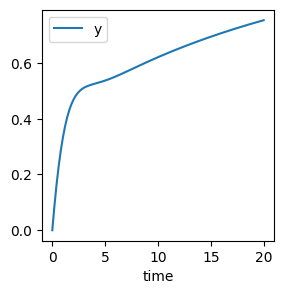

In [21]:
times = np.linspace(0, 20, 200)
plotSys(gRM_tf, times=times, forced_input=1, figsize=(3,3))

### Poles

In [22]:
# Examine the poles.
gRM_tf.poles()

array([-0.8184966 +0.63218785j, -0.8184966 -0.63218785j,
       -0.68      +0.j        , -0.04300681+0.j        ,
        0.        +0.j        ])

What is the dominant pole, the pole the determines how fast the system converges.

### DC Gain

In [23]:
gRM_tf.dcgain()

nan

Why is this? It should be 1 because we have I-control. The issue is that we need to factor out an $s$.

In [26]:
s = sympy.symbols("s")
numr = 46*s**4 + 81.88*s**3 + 39.01*s**2 + 3.128*s
numr = (numr/s).simplify()
denom = 100*s**5 + 236*s**4 + 228.2*s**3 + 82.12*s**2 + 3.128*s
denom = (denom/s).simplify()
gRM = (numr)/(denom)
gRM

(46*s**3 + 81.88*s**2 + 39.01*s + 3.128)/(100*s**4 + 236*s**3 + 228.2*s**2 + 82.12*s + 3.128)

In [25]:
# Evaluating a sympy expression with a variable substitution
gRY.subs({s: 0})

1.00000000000000

### Effect of controller
What happens to the poles and DC Gain when $k_P$ changes from 1 to 10?

## Questions
1. What is the DC Gain of $G_{RY} (s)$? 
   1. Suppose $G_C (0 ) = 0 = G_O (0)$.
   1. For the following, $G_C (0 ) \neq 0 \neq G_O (0)$.
       1. $G_F (0) = 1$
       1. $G_F (0) \neq 1$
1. Repeat this question for the case where $G_C (s) = k_P + \frac{k_I}{s}$, integral control. 

# Exercise: Constructing closed loop transfer functions

## Wolf model

Consider a closed loop system in which there is no filter.

Find $G_{RM}$ for a PI controller where $k_I = 0.1$ and $k_P = 1$.

$G_{RM} = \frac{ G_C (s) G_O(s) }{1 + G_C (s) G_O(s) G_F(s)}$

**Hints**
1. Find $G_O(s)$
1. Write the equations for the other transfer functions
1. Use algebra on transfer functions to find $G_{RM}$